**모든 모델을 기본적으로 적용해보기**

---

- 선형회귀
- RandomForestRegressor
- XgBoostRegressor
- LGBMRegressor



## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ftr = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sampleSubmission.csv')

### Datetime

In [3]:
def datetime(ftr):
    df = ftr.copy()
    df.datetime = pd.to_datetime(df.datetime)
    df['year']=df.datetime.dt.year
    df['month']=df.datetime.dt.month
    df['day']=df.datetime.dt.day
    df['hour']=df.datetime.dt.hour
    return df

In [4]:
ftr_n = datetime(ftr)

In [5]:
ftr_n.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [6]:
def draw(model,x=None,y=None,hue=None,data=ftr_n,title=None,pal=None):
    plt.figure(figsize=(6,6))
    model(x=x,y=y,data=data,hue=hue,palette=pal)    
    plt.title(title)

### Season
- 계절에 따른 영향이 뚜렷하지 않음
- month를 온도/체감온도를 기준으로 클러스터링을 해보기로 함(월별 대여량 추이와 월별 온도/체감온도 추이가 가장 유사)
- 의문점: Season 변수가 과연 필요할까? 계절이라는 것은 결국 온도 등의 날씨를 카테고리화한 것인데

In [7]:
ftr_n[['month','temp','count']].groupby('month').mean()

,temp,count
month,,
1,9.840000,90.366516
2,11.798535,110.003330
3,15.902175,148.169811
4,18.718372,184.160616
5,22.674079,219.459430
6,27.064496,242.031798
7,30.841711,235.325658
8,29.736689,234.118421
9,25.779032,233.805281


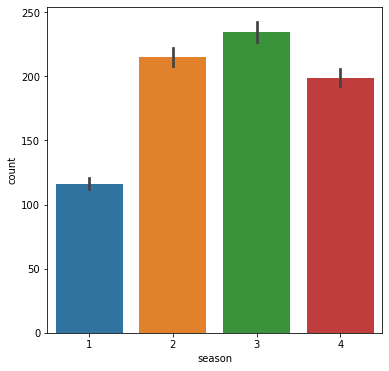

In [8]:
draw(sns.barplot, 'season','count')

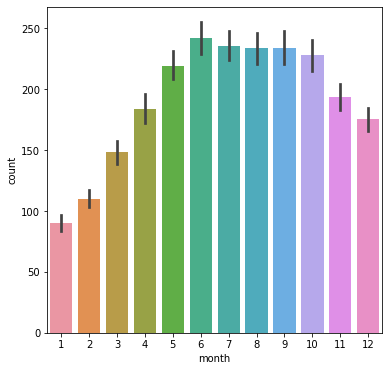

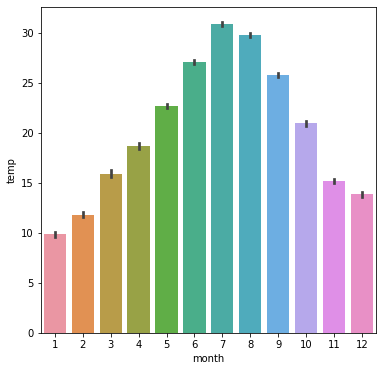

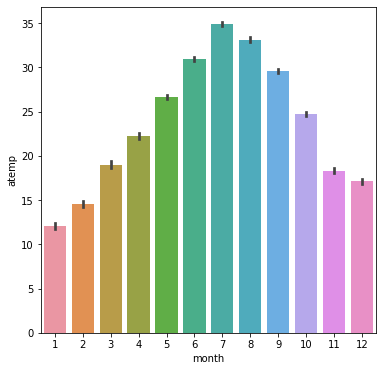

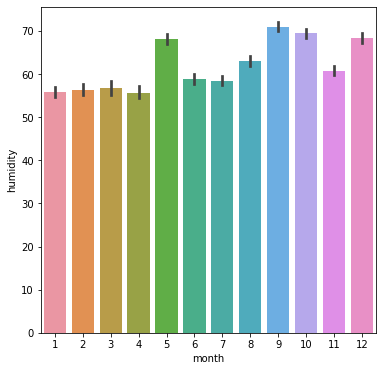

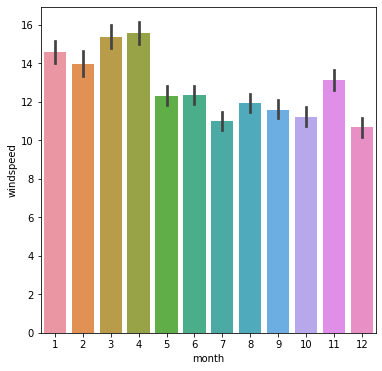

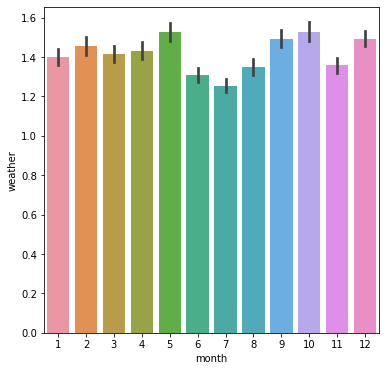

In [9]:
draw(sns.barplot,'month','count')
draw(sns.barplot,'month','temp')
draw(sns.barplot,'month','atemp')
draw(sns.barplot,'month','humidity')
draw(sns.barplot,'month','windspeed')
draw(sns.barplot,'month','weather')

In [10]:
month_season = ftr_n[['month','temp','atemp','count','season']].groupby('month').mean().reset_index()
month_season

,month,temp,atemp,count,season
0,1,9.840000,12.077579,90.366516,1.0
1,2,11.798535,14.532608,110.003330,1.0
2,3,15.902175,19.017220,148.169811,1.0
3,4,18.718372,22.305891,184.160616,2.0
4,5,22.674079,26.632374,219.459430,2.0
5,6,27.064496,30.988750,242.031798,2.0
6,7,30.841711,34.900395,235.325658,3.0
7,8,29.736689,33.122001,234.118421,3.0
8,9,25.779032,29.590248,233.805281,3.0
9,10,20.933853,24.739682,227.699232,4.0


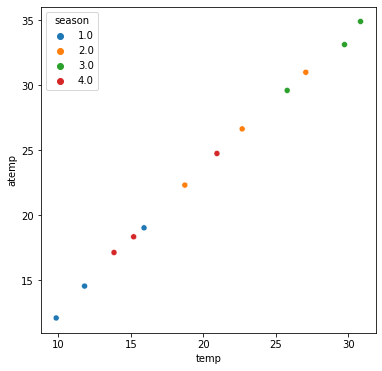

In [11]:
draw(sns.scatterplot, 'temp','atemp',hue='season',data=month_season,pal='tab10')

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans.fit(month_season[['temp','atemp']])

KMeans(n_clusters=4, random_state=0)

In [13]:
kmeans.labels_

array([2, 2, 3, 0, 0, 1, 1, 1, 1, 0, 3, 3])

In [14]:
month_season['new_season']=kmeans.labels_

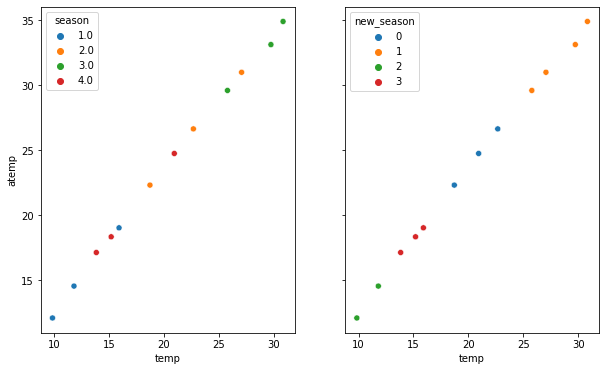

In [15]:
f, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True)
sns.scatterplot(x='temp',y='atemp',hue='season',data=month_season,ax=ax[0],palette='tab10')
sns.scatterplot(x='temp',y='atemp',hue='new_season',data=month_season,ax=ax[1],palette='tab10')
plt.show()

In [16]:
month_season

,month,temp,atemp,count,season,new_season
0,1,9.840000,12.077579,90.366516,1.0,2
1,2,11.798535,14.532608,110.003330,1.0,2
2,3,15.902175,19.017220,148.169811,1.0,3
3,4,18.718372,22.305891,184.160616,2.0,0
4,5,22.674079,26.632374,219.459430,2.0,0
5,6,27.064496,30.988750,242.031798,2.0,1
6,7,30.841711,34.900395,235.325658,3.0,1
7,8,29.736689,33.122001,234.118421,3.0,1
8,9,25.779032,29.590248,233.805281,3.0,1
9,10,20.933853,24.739682,227.699232,4.0,0


In [17]:
month_season.new_season=month_season.new_season.map({2:1,3:4,0:2,1:3})

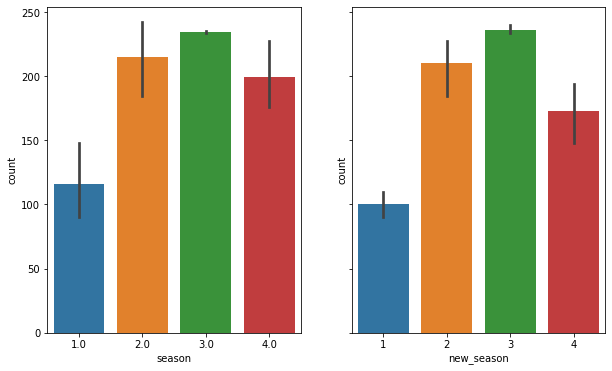

In [18]:
f, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True)
sns.barplot(x='season',y='count',data=month_season,ax=ax[0])
sns.barplot(x='new_season',y='count',data=month_season,ax=ax[1])
plt.show()

In [19]:
month_season

,month,temp,atemp,count,season,new_season
0,1,9.840000,12.077579,90.366516,1.0,1
1,2,11.798535,14.532608,110.003330,1.0,1
2,3,15.902175,19.017220,148.169811,1.0,4
3,4,18.718372,22.305891,184.160616,2.0,2
4,5,22.674079,26.632374,219.459430,2.0,2
5,6,27.064496,30.988750,242.031798,2.0,3
6,7,30.841711,34.900395,235.325658,3.0,3
7,8,29.736689,33.122001,234.118421,3.0,3
8,9,25.779032,29.590248,233.805281,3.0,3
9,10,20.933853,24.739682,227.699232,4.0,2


In [20]:
ftr_n['new_season']=ftr_n.month.map(dict(zip(month_season.month,month_season.new_season)))

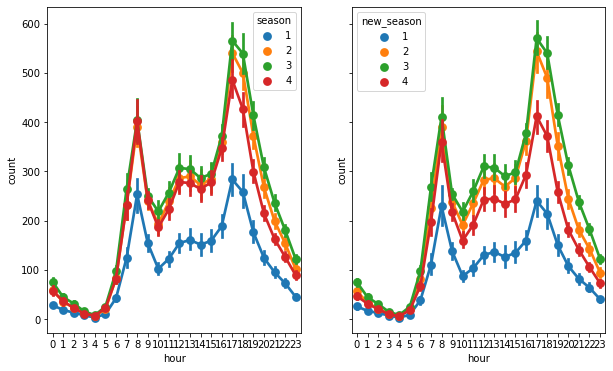

In [21]:
f, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True)
sns.pointplot(x='hour',y='count',hue='season',data=ftr_n,ax=ax[0])
sns.pointplot(x='hour',y='count',hue='new_season',data=ftr_n,ax=ax[1])
plt.show()

- 격차가 어느 정도는 뚜렷해진 모습
- 성능 비교를 위해 일단 기존 season 칼럼은 유지
- 단점 존재할 수 있음: 온도/체감온도 외 다른 변수들은 간과

### Humidity
- 2011-03-10의 습도가 0 (결측치)
- 3월 10일의 날씨가 유사한 날은 2011-03-06, 이 날의 평균 습도로 대체

In [22]:
v = ftr_n[ftr_n.datetime.dt.date==pd.to_datetime('2011-03-06')]['humidity'].mean()

In [23]:
ftr_n[ftr_n.datetime.dt.date==pd.to_datetime('2011-03-10')].index

Int64Index([1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101,
            1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112],
           dtype='int64')

In [24]:
ftr_n.loc[1091:1112,'humidity']=v

In [25]:
ftr_n[ftr_n.datetime.dt.date==pd.to_datetime('2011-03-10')]['humidity']

1091    94.826087
1092    94.826087
1093    94.826087
1094    94.826087
1095    94.826087
1096    94.826087
1097    94.826087
1098    94.826087
1099    94.826087
1100    94.826087
1101    94.826087
1102    94.826087
1103    94.826087
1104    94.826087
1105    94.826087
1106    94.826087
1107    94.826087
1108    94.826087
1109    94.826087
1110    94.826087
1111    94.826087
1112    94.826087
Name: humidity, dtype: float64

### WindSpeed

In [26]:
wind = ftr_n[ftr_n.windspeed!=0]
notwind = ftr_n[ftr_n.windspeed==0]

In [27]:
wind.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,new_season
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.88,75.0,6.0032,0,1,1,2011,1,1,5,1


In [28]:
windcol = ["season","weather","humidity","month","temp","year","atemp"]

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

In [30]:
xgb_reg = XGBRegressor(n_jobs=-1,random_state=0)
lgbm_reg = LGBMRegressor(n_jobs=-1,random_state=0)
rf_reg = RandomForestRegressor(n_jobs=-1,random_state=0)

In [31]:
xgb_score=cross_val_score(xgb_reg, wind[windcol],wind.windspeed, n_jobs=-1, cv=3,scoring='neg_mean_squared_log_error')
lgbm_score=cross_val_score(lgbm_reg, wind[windcol],wind.windspeed, n_jobs=-1, cv=3,scoring='neg_mean_squared_log_error')
rf_score=cross_val_score(rf_reg, wind[windcol],wind.windspeed, n_jobs=-1, cv=3,scoring='neg_mean_squared_log_error')

In [32]:
print(np.mean(xgb_score))
print(np.mean(lgbm_score))
print(np.mean(rf_score))

-0.1843047009237171
-0.13606755567838233
-0.16961209132555533


In [33]:
lgbm_reg.fit(wind[windcol],wind.windspeed)
predict = lgbm_reg.predict(notwind[windcol])

In [34]:
predict

array([ 6.02607651,  6.10179009,  6.10179009, ...,  8.97939356,
       11.31053986,  8.11981179])

In [35]:
ftr_w = ftr_n.copy()
ftr_w.loc[ftr_w.windspeed==0,'windspeed'] = predict

In [36]:
ftr_w[ftr_w.windspeed==0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,new_season


### Abnormal Holiday
- 2011.04.15와 2012.04.16은 오히려 평일에 가까운 추이를 보임
- 이 날은 워싱턴에서만 챙기는 기념일인것 같음 (참고: [미국 공휴일](https://www.timeanddate.com/holidays/us/2011))

In [37]:
ftr_w['date']=ftr_w.datetime.apply(lambda x:str(x).split()[0])

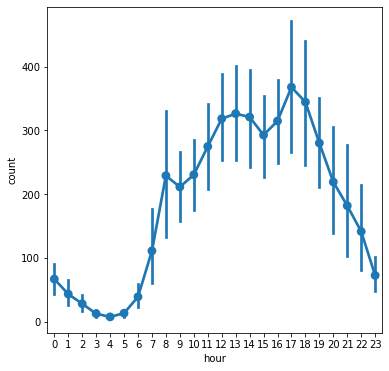

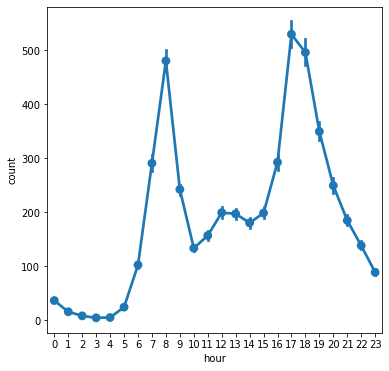

In [38]:
draw(sns.pointplot, x='hour',y='count',data=ftr_w[ftr_w.holiday==1])
draw(sns.pointplot, x='hour',y='count',data=ftr_w[ftr_w.workingday==1])

holiday, workingday를 종합한 변수 만들기
- holiday = 0 & workingday = 0 => weekend
- holiday = 0 & workingday = 1 => weekday
- holiday = 1 & workingday = 0 => holiday

In [44]:
for x in ftr_w.holiday.unique():
    print('holiday:',x,' workingday:',ftr_w[ftr_w.holiday == x]['workingday'].unique())

holiday: 0  workingday: [0 1]
holiday: 1  workingday: [0]


In [45]:
ftr_w.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,new_season,date
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,6.026077,3,13,16,2011,1,1,0,1,2011-01-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,6.101790,8,32,40,2011,1,1,1,1,2011-01-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,6.101790,5,27,32,2011,1,1,2,1,2011-01-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75.0,6.239811,3,10,13,2011,1,1,3,1,2011-01-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75.0,6.239811,0,1,1,2011,1,1,4,1,2011-01-01


In [47]:
ftr_w['day_div']=''

ftr_w['day_div'][(ftr_w.holiday == 0) & (ftr_w.workingday == 0)]='weekend'
ftr_w['day_div'][(ftr_w.holiday == 0) & (ftr_w.workingday == 1)]='weekday'
ftr_w['day_div'][(ftr_w.holiday == 1) & (ftr_w.workingday == 0)]='holiday'    

<ipython-input-47-63162ff56c8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftr_w['day_div'][(ftr_w.holiday == 0) & (ftr_w.workingday == 0)]='weekend'
<ipython-input-47-63162ff56c8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftr_w['day_div'][(ftr_w.holiday == 0) & (ftr_w.workingday == 1)]='weekday'
<ipython-input-47-63162ff56c8d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftr_w['day_div'][(ftr_w.holiday == 1) & (ftr_w

In [49]:
ftr_w['day_div'].unique()

array(['weekend', 'weekday', 'holiday'], dtype=object)

In [57]:
ftr_w.day_div[ftr_w.date=='2011-04-15']='weekday'
ftr_w.day_div[ftr_w.date=='2012-04-16']='weekday'

<ipython-input-57-d411f06df0f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftr_w.day_div[ftr_w.date=='2011-04-15']='weekday'
<ipython-input-57-d411f06df0f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftr_w.day_div[ftr_w.date=='2012-04-16']='weekday'


In [60]:
ftr_w.day_div[ftr_w.date=='2011-04-15'].unique()
ftr_w.day_div[ftr_w.date=='2012-04-16'].unique()

array(['weekday'], dtype=object)

### Delete Columns

In [62]:
ftr_w.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,new_season,date,day_div
0,2011-01-01,1,0,0,1,9.84,14.395,81.0,6.026077,3,13,16,2011,1,1,0,1,2011-01-01,weekend


In [69]:
ftr_w_2 = ftr_w.drop(['datetime','season','holiday','workingday','casual','registered','count','day','date']
                     ,axis=1)
ftr_w_2.head()

,weather,temp,atemp,humidity,windspeed,year,month,hour,new_season,day_div
0,1,9.84,14.395,81.0,6.026077,2011,1,0,1,weekend
1,1,9.02,13.635,80.0,6.101790,2011,1,1,1,weekend
2,1,9.02,13.635,80.0,6.101790,2011,1,2,1,weekend
3,1,9.84,14.395,75.0,6.239811,2011,1,3,1,weekend
4,1,9.84,14.395,75.0,6.239811,2011,1,4,1,weekend


In [70]:
label = ftr_w['count']

In [71]:
label

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

### One-Hot Encoding

In [73]:
ftr_w_2.columns

Index(['weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month',
       'hour', 'new_season', 'day_div'],
      dtype='object')

In [74]:
ftr_w_ohe = pd.get_dummies(ftr_w_2,columns=['weather','year','month','hour','new_season','day_div'])

In [75]:
ftr_w_ohe

,temp,atemp,humidity,windspeed,weather_1,weather_2,weather_3,weather_4,year_2011,year_2012,...,hour_21,hour_22,hour_23,new_season_1,new_season_2,new_season_3,new_season_4,day_div_holiday,day_div_weekday,day_div_weekend
0,9.84,14.395,81.0,6.026077,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,9.02,13.635,80.0,6.101790,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,9.02,13.635,80.0,6.101790,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,9.84,14.395,75.0,6.239811,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,9.84,14.395,75.0,6.239811,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50.0,26.002700,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
10882,14.76,17.425,57.0,15.001300,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
10883,13.94,15.910,61.0,15.001300,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,1,0
10884,13.94,17.425,61.0,6.003200,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0


### Log on Label

In [76]:
label

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

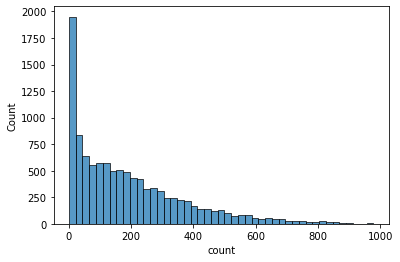

In [79]:
sns.histplot(data=label)
plt.show()

In [81]:
label_log = np.log1p(label)

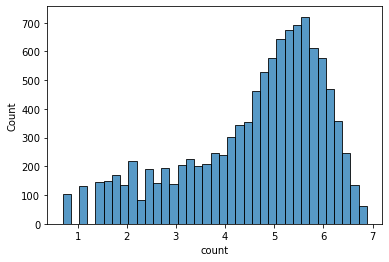

In [82]:
sns.histplot(data=label_log)
plt.show()

## Modeling
### LinearRegression

In [96]:
def RMSLE(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def model_val(model, ftr, lb):
    X_train, X_val, y_train, y_val = train_test_split(ftr,lb,test_size=0.2,
                                                      random_state=0)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    
    return RMSLE(np.expm1(y_val), np.expm1(pred))    

In [87]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [95]:
ftr_w_ohe.shape

(10886, 53)

In [88]:
lr_reg = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.01)

In [97]:
models = [lr_reg, ridge,lasso]

for model in models:
    print(model, ':',model_val(model, ftr_w_ohe,label_log))

LinearRegression() : 0.5947701974550454
Ridge(alpha=10) : 0.5953628062588665
Lasso(alpha=0.01) : 0.6398962523643843


### Other Regressor

In [107]:
rf_reg = RandomForestRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

models = [rf_reg,xgb_reg,lgbm_reg]

for model in models:
    print(model, ':',model_val(model, ftr_w_ohe,label_log))

RandomForestRegressor(n_estimators=500) : 0.356601371714985
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) : 0.34627794617439633
LGBMRegressor(n_estimators=500) : 0.32274817947904


In [108]:
lgbm_reg.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 500,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': True,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x2394444e5b0>,
 '_evals_result': None,
 '_best_score': defaultdict(collections.OrderedDict, {}),
 '_best_iteration': None,
 '_other_params': {},
 '_objective': 'regression',
 'class_weight': None,
 '_class_weight': None,
 '_class_map': None,
 '_n_features': 53,
 '_n_features_in': 53,
 '_classes': None,
 '_n_classes': None,
 '_fobj': None,
 'fitted_': True}

## Submission
### LGBM
- 0.48

In [135]:
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0
12,2011-01-20 12:00:00,1,0,1,2,12.30,16.665,42,0.0
60,2011-01-22 13:00:00,1,0,0,1,3.28,8.335,35,0.0
62,2011-01-22 15:00:00,1,0,0,1,4.92,7.575,28,0.0
...,...,...,...,...,...,...,...,...,...
6433,2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,0.0
6434,2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,0.0
6436,2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,0.0
6444,2012-12-29 23:00:00,1,0,0,2,10.66,12.120,60,0.0


In [118]:
te2 = test.copy()

In [119]:
te2 = datetime(te2)

te2['new_season'] = 0  
te2['new_season']=ftr_n.month.map(dict(zip(month_season.month,month_season.new_season)))

te2['day_div']=''
te2['day_div'][(te2.holiday == 0) & (te2.workingday == 0)]='weekend'
te2['day_div'][(te2.holiday == 0) & (te2.workingday == 1)]='weekday'
te2['day_div'][(te2.holiday == 1) & (te2.workingday == 0)]='holiday'    

<ipython-input-119-79abf0290f36>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te2['day_div'][(te2.holiday == 0) & (te2.workingday == 0)]='weekend'
<ipython-input-119-79abf0290f36>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te2['day_div'][(te2.holiday == 0) & (te2.workingday == 1)]='weekday'
<ipython-input-119-79abf0290f36>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te2['day_div'][(te2.holiday == 1) & (te2.workingday == 

In [120]:
te2.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,new_season,day_div
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,1,weekday
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,1,weekday
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,1,weekday
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,1,weekday
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,1,weekday


In [121]:
te3 = te2.drop(['datetime','season','holiday','workingday','day'],axis=1)
te3_ohe = pd.get_dummies(te3,columns=['weather','year','month','hour','new_season','day_div'])

In [122]:
te3_ohe

,temp,atemp,humidity,windspeed,weather_1,weather_2,weather_3,weather_4,year_2011,year_2012,...,hour_21,hour_22,hour_23,new_season_1,new_season_2,new_season_3,new_season_4,day_div_holiday,day_div_weekday,day_div_weekend
0,10.66,11.365,56,26.0027,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,10.66,13.635,56,0.0000,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,10.66,13.635,56,0.0000,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,10.66,12.880,56,11.0014,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,10.66,12.880,56,11.0014,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,10.66,12.880,60,11.0014,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
6489,10.66,12.880,60,11.0014,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
6490,10.66,12.880,60,11.0014,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,1,0
6491,10.66,13.635,56,8.9981,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0


In [123]:
lgbm_reg = LGBMRegressor(n_estimators=1000,random_state=0)
lgbm_reg.fit(ftr_w_ohe, label_log)
predict = lgbm_reg.predict(te3_ohe)

In [128]:
answer_lgbm = sample.copy()
answer_lgbm['count']=np.expm1(predict)

In [129]:
answer_lgbm

,datetime,count
0,2011-01-20 00:00:00,10.726440
1,2011-01-20 01:00:00,4.517896
2,2011-01-20 02:00:00,3.511243
3,2011-01-20 03:00:00,3.308545
4,2011-01-20 04:00:00,1.391420
...,...,...
6488,2012-12-31 19:00:00,375.425600
6489,2012-12-31 20:00:00,233.851752
6490,2012-12-31 21:00:00,190.765795
6491,2012-12-31 22:00:00,135.231709


In [130]:
answer_lgbm.to_csv('./ans_lgbm.csv',index=False)

### Xgboost
- 0.53

In [132]:
xgb_reg = XGBRegressor(n_estimators=1000,random_state=0)
xgb_reg.fit(ftr_w_ohe, label_log)
predict = xgb_reg.predict(te3_ohe)

answer_xgb = sample.copy()
answer_xgb['count']=np.expm1(predict)

answer_xgb.to_csv('./ans_xgb.csv',index=False)

- 오히려 성능이 안나오길래 확인해봤더니, test 데이터에도 풍속이 0인 데이터가 많이 존재
- train 데이터와 똑같이 풍속 변환

In [138]:
te2 = datetime(te2)

# 계절 재정의
te2['new_season'] = 0  
te2['new_season']=te2.month.map(dict(zip(month_season.month,month_season.new_season)))

# 풍속 결측치 변환
wind = te2[te2.windspeed!=0]
notwind = te2[te2.windspeed==0]

lgbm_reg = LGBMRegressor(n_jobs=-1,random_state=0)
lgbm_reg.fit(wind[windcol],wind.windspeed)

predict = lgbm_reg.predict(notwind[windcol])
te_w = te2.copy()
te_w.loc[te_w.windspeed==0,'windspeed'] = predict

# workingday & holiday 변수 조합 => day_div
te_w['day_div']=''
te_w['day_div'][(te_w.holiday == 0) & (te_w.workingday == 0)]='weekend'
te_w['day_div'][(te_w.holiday == 0) & (te_w.workingday == 1)]='weekday'
te_w['day_div'][(te_w.holiday == 1) & (te_w.workingday == 0)]='holiday'    

<ipython-input-138-81c2500af2be>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te_w['day_div'][(te_w.holiday == 0) & (te_w.workingday == 0)]='weekend'
<ipython-input-138-81c2500af2be>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te_w['day_div'][(te_w.holiday == 0) & (te_w.workingday == 1)]='weekday'
<ipython-input-138-81c2500af2be>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te_w['day_div'][(te_w.holiday == 1) & (te_w.wo

In [143]:
ftr_w[['month','new_season']].groupby('month').mean()

,new_season
month,
1,1
2,1
3,4
4,2
5,2
6,3
7,3
8,3
9,3


In [144]:
te_w[['month','new_season']].groupby('month').mean()

,new_season
month,
1,1
2,1
3,4
4,2
5,2
6,3
7,3
8,3
9,3


In [145]:
(te_w.windspeed==0).sum()

0

<AxesSubplot:xlabel='humidity', ylabel='Count'>

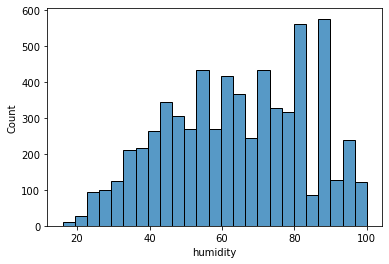

In [146]:
sns.histplot(te_w.humidity)

In [150]:
for h in te_w.holiday.unique():
    for w in te_w[te_w.holiday == h]['workingday'].unique():
        print('holiday:',h,' workingday:',w,'day_div:',
              te_w[(te_w.holiday == h)&(te_w.workingday == w)]['day_div'].unique())

holiday: 0  workingday: 1 day_div: ['weekday']
holiday: 0  workingday: 0 day_div: ['weekend']
holiday: 1  workingday: 0 day_div: ['holiday']


In [151]:
te_w.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,new_season,day_div
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.002700,2011,1,20,0,1,weekday
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,8.417818,2011,1,20,1,1,weekday
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,8.417818,2011,1,20,2,1,weekday
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,20,3,1,weekday
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,20,4,1,weekday


In [152]:
te3 = te2.drop(['datetime','season','holiday','workingday','day'],axis=1)
te3_ohe = pd.get_dummies(te3,columns=['weather','year','month','hour','new_season','day_div'])

In [153]:
te3_ohe.shape

(6493, 53)

### LGBM (again)
- 0.49

In [154]:
lgbm_reg = XGBRegressor(n_estimators=1000,random_state=0)
lgbm_reg.fit(ftr_w_ohe, label_log)
predict = xgb_reg.predict(te3_ohe)

answer_lgbm = sample.copy()
answer_lgbm['count']=np.expm1(predict)

answer_lgbm.to_csv('./ans_lgbm_2.csv',index=False)

### XGB (again)
- 0.49

In [155]:
xgb_reg = XGBRegressor(n_estimators=1000,random_state=0)
xgb_reg.fit(ftr_w_ohe, label_log)
predict = xgb_reg.predict(te3_ohe)

answer_xgb = sample.copy()
answer_xgb['count']=np.expm1(predict)

answer_xgb.to_csv('./ans_xgb_2.csv',index=False)

- 아무래도 과적합이 일어난듯 하다..